# Evaluating Classifiers

## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [7]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [8]:
from sklearn.model_selection import train_test_split

In [63]:
full_train, test = train_test_split(df, test_size=0.2, random_state=1)
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

train.shape, val.shape, test.shape

((2672, 14), (891, 14), (891, 14))

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [42]:
from sklearn.metrics import auc, roc_auc_score

for col in ['seniority', 'time', 'income', 'debt']:
    a = roc_auc_score(train['default'], train[col])
    print(f"{col:15}  {a:7.4f}")

seniority         0.2906
time              0.5609
income            0.3180
debt              0.4952


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [64]:
Xfull_train = full_train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
Xtrain = train[['seniority', 'income', 'assets', 'records', 'job', 'home']]
Xval = val[['seniority', 'income', 'assets', 'records', 'job', 'home']]
Xtest = test[['seniority', 'income', 'assets', 'records', 'job', 'home']]

In [65]:
yfull_train = full_train['default']
ytrain = train['default']
yval = val['default']
ytest = test['default']

In [45]:
from sklearn.feature_extraction import DictVectorizer

train_dict = Xtrain.to_dict(orient='records')
train_dict[0]

{'seniority': 12,
 'income': 102,
 'assets': 0,
 'records': 'no',
 'job': 'fixed',
 'home': 'private'}

In [46]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
Xtrain_trans = dv.transform(train_dict)
Xtrain_trans.shape

(2672, 17)

In [47]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
m.fit(Xtrain_trans, ytrain)
m.score(Xtrain_trans, ytrain)

0.7945359281437125

In [48]:
val_dict = Xval.to_dict(orient='records')
Xval_trans = dv.transform(val_dict)
m.score(Xval_trans, yval)

0.7800224466891134

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [53]:
proba = m.predict_proba(Xval_trans)[:,1]
roc_auc_score(yval, proba)

0.8120879813449298

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [55]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

In [59]:
precisions = []
recalls = []
ts = np.linspace(0.0, 1.0, num=101)
for threshold in ts:
    ypred = (proba > threshold).round().astype(int)
    precisions.append(precision_score(yval, ypred))
    recalls.append(recall_score(yval, ypred))

/home/kristian/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kristian/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: Undefi

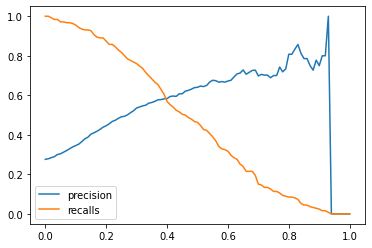

In [60]:
from matplotlib import pyplot as plt

plt.plot(ts, precisions, label='precision')
plt.plot(ts, recalls, label='recalls')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

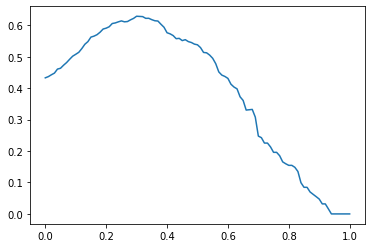

In [62]:
from sklearn.metrics import f1_score

f1 = []
for threshold in ts:
    ypred = (proba > threshold).round().astype(int)
    f1.append(f1_score(yval, ypred))
    
plt.plot(ts, f1)

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [72]:
full_train.shape

(3563, 14)

In [89]:
from sklearn.model_selection import KFold

def kfold_model(C=1.0):
    auc_values = []

    print(f'cross-validation with C={C}')
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    for a, b in kf.split(full_train):
        #print(a.shape, b.shape)
        kftrain = full_train.iloc[a]
        kfval = full_train.iloc[b]

        kfXtrain = kftrain[['seniority', 'income', 'assets', 'records', 'job', 'home']]
        kfXval = kfval[['seniority', 'income', 'assets', 'records', 'job', 'home']]

        kfytrain = kftrain['default']
        kfyval = kfval['default']

        train_dict = kfXtrain.to_dict(orient='records') 
        val_dict = kfXval.to_dict(orient='records')
        kfXtrain_trans = dv.transform(train_dict)
        kfXval_trans = dv.transform(val_dict)

        m = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        m.fit(kfXtrain_trans, kfytrain)
        train_acc = m.score(kfXtrain_trans, kfytrain)
        val_acc = m.score(kfXval_trans, kfyval)

        proba = m.predict_proba(kfXval_trans)[:,1]
        auc = roc_auc_score(kfyval, proba)
        auc_values.append(auc)

        print(f"train: {train_acc:5.3f}   val: {val_acc:5.3f}  auc: {auc:8.4f}")

    mean = np.array(auc_values).mean().round(3)
    std = np.array(auc_values).std().round(3)
    print(f"mean crossval score: {mean:6.3f}   stddev: {std:6.3f}")

In [90]:
kfold_model()

cross-validation with C=1.0
train: 0.788   val: 0.792  auc:   0.8256
train: 0.776   val: 0.784  auc:   0.8254
train: 0.797   val: 0.791  auc:   0.7893
train: 0.771   val: 0.772  auc:   0.8153
train: 0.784   val: 0.767  auc:   0.8055
mean crossval score:  0.812   stddev:  0.014


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [92]:
for C in [0.01, 0.1, 1, 10]:
    kfold_model(C)
    print()

cross-validation with C=0.01
train: 0.774   val: 0.773  auc:   0.8204
train: 0.773   val: 0.776  auc:   0.8207
train: 0.769   val: 0.783  auc:   0.7890
train: 0.771   val: 0.774  auc:   0.8137
train: 0.776   val: 0.757  auc:   0.7990
mean crossval score:  0.809   stddev:  0.013

cross-validation with C=0.1
train: 0.792   val: 0.790  auc:   0.8233
train: 0.775   val: 0.785  auc:   0.8253
train: 0.793   val: 0.787  auc:   0.7894
train: 0.787   val: 0.791  auc:   0.8213
train: 0.782   val: 0.764  auc:   0.8053
mean crossval score:  0.813   stddev:  0.014

cross-validation with C=1
train: 0.788   val: 0.792  auc:   0.8256
train: 0.776   val: 0.784  auc:   0.8254
train: 0.797   val: 0.791  auc:   0.7893
train: 0.771   val: 0.772  auc:   0.8153
train: 0.784   val: 0.767  auc:   0.8055
mean crossval score:  0.812   stddev:  0.014

cross-validation with C=10
train: 0.788   val: 0.792  auc:   0.8256
train: 0.776   val: 0.784  auc:   0.8254
train: 0.797   val: 0.791  auc:   0.7893
train: 0.792  

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.